In [1]:
import sys
import os

# Get the path to the parent directory (consumption)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to the Python path
sys.path.append(parent_dir)

# Now you can import the LSTMModel from the dnn.models module
from dnn.models import LinearRegressionModel
from dnn.dataset import Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sklearn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


from sklearn.model_selection import train_test_split

# Load data

In [3]:
# Load full heating and cooling timeseries
with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_heating_timeseries.pkl', 'rb') as f:
    full_heating_timeseries = pickle.load(f)
with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_cooling_timeseries.pkl', 'rb') as f:
    full_cooling_timeseries = pickle.load(f)

### Weather data

In [4]:
weather_data = pd.read_csv("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/G2500170_2018.csv")

In [5]:
# Change date time column name to timestamp
weather_data.rename(columns={'date_time': "timestamp"}, inplace=True)
weather_data.set_index('timestamp', inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

# Delete all columns except dry bulb temperature
weather_data = weather_data[["Dry Bulb Temperature [°C]"]]
weather_data.rename(columns={"Dry Bulb Temperature [°C]": "temperature"}, inplace=True)

# Create an entry for 2018-01-01 00:00:00
new_row = pd.DataFrame({'temperature': weather_data.iloc[0]['temperature']}, index=[pd.to_datetime('2018-01-01 00:00:00')])
weather_data = pd.concat([new_row, weather_data])

# Remove last 19 rows
weather_data = weather_data[:-24]

### ResStock

In [6]:
resstock = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/MA_baseline_metadata_and_annual_results.parquet")

In [44]:
len(resstock)

11707

### Building timeseries

In [7]:
building_data = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/1000-0.parquet")

In [8]:
def get_cols(building_data: pd.DataFrame, building_id: int) -> str:

    try:
        building = building_data.loc[building_id]
    except:
        raise ValueError("Building ID not found in the dataset")

    match building["in.heating_fuel"]:
        case  "Natural Gas":
            return "out.natural_gas.heating.energy_consumption"
        case "Electricity":
            return "out.electricity.heating.energy_consumption"
        case "Fuel Oil":
            return "out.fuel_oil.heating.energy_consumption"
        case "Propane":
            return "out.propane.heating.energy_consumption"
        case _:
            return "out.electricity.heating.energy_consumption"

In [9]:
col_to_use = get_cols(resstock, 1000)
consumption_timeseries = building_data[["timestamp", col_to_use]]

# Resample to hourly data
consumption_timeseries["timestamp"] = pd.to_datetime(consumption_timeseries["timestamp"])
consumption_timeseries.set_index("timestamp", inplace=True)
consumption_timeseries = consumption_timeseries.resample("h").mean()
consumption_timeseries = consumption_timeseries[col_to_use]

consumption_timeseries = consumption_timeseries[:-24]

# Turn into dataframe
consumption_timeseries = pd.DataFrame(consumption_timeseries)
consumption_timeseries.rename(columns={col_to_use: "consumption"}, inplace=True)

/var/folders/bw/4qyc6pj92bdb1bv22yhll2zw0000gn/T/ipykernel_10606/316304138.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumption_timeseries["timestamp"] = pd.to_datetime(consumption_timeseries["timestamp"])


In [10]:
exog_variables = pd.merge(
    consumption_timeseries,
    weather_data,
    left_index=True,
    right_index=True,
)

In [11]:
heating_timeseries = full_heating_timeseries[1000]
cooling_timeseries = full_cooling_timeseries[1000]

heating_timeseries = pd.concat([heating_timeseries.loc["2018-01-01":"2018-05-31"], heating_timeseries.loc["2018-11-01":"2018-12-31"]])
cooling_timeseries = cooling_timeseries.loc["2018-06-01":"2018-10-31"]

In [12]:
heating_exog = exog_variables.loc[heating_timeseries.index]
cooling_exog = exog_variables.loc[cooling_timeseries.index]

In [13]:
heating_data = pd.merge(
    heating_timeseries,
    heating_exog,
    left_index=True,
    right_index=True,
)
heating_data.reset_index(drop=True, inplace=True)
cooling_data = pd.merge(
    cooling_timeseries,
    cooling_exog,
    left_index=True,
    right_index=True,
)
cooling_data.reset_index(drop=True, inplace=True)

In [14]:
def generate_sequences(data, seq_len=24):
    sequences = []
    labels = []

    for i in range(len(data) - seq_len):
        seq = data.iloc[i:i + seq_len]
        label = data.iloc[i + seq_len].iloc[0]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Heating prediction

In [15]:
train_split = 0.8

heating_train_data = heating_data[:int(len(heating_data) * train_split)]
heating_test_data = heating_data[int(len(heating_data) * train_split):]

In [16]:
heating_train_sequences, heating_train_labels = generate_sequences(heating_train_data)
heating_test_sequences, heating_test_labels = generate_sequences(heating_test_data)

In [17]:
heating_train_sequences = heating_train_sequences.reshape(heating_train_sequences.shape[0], -1)
heating_test_sequences = heating_test_sequences.reshape(heating_test_sequences.shape[0], -1)

In [18]:
batch_size = 32

heating_train_dataset = Dataset(X=heating_train_sequences, y=heating_train_labels)
heating_test_dataset = Dataset(X=heating_test_sequences, y=heating_test_labels)

heating_train_loader = DataLoader(heating_train_dataset, batch_size=batch_size, shuffle=True)
heating_test_loader = DataLoader(heating_test_dataset, batch_size=batch_size, shuffle=False)

## Instantiate model

In [19]:
heating_model = LinearRegressionModel(input_size=heating_train_sequences.shape[1], output_size=1)

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(heating_model.parameters(), lr=0.001)

In [21]:
# Training function
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for sequences, labels in train_loader:
            # Zero gradients
            sequences = sequences.float()
            labels = labels.float().unsqueeze(1)  # Unsqueeze to match output dim
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)  # Unsqueeze labels to match output dim
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')


In [22]:
num_epochs = 10
train(heating_model, heating_train_loader, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/10, Loss: 939.7047
Epoch 2/10, Loss: 3.3371
Epoch 3/10, Loss: 1.3215
Epoch 4/10, Loss: 0.9324
Epoch 5/10, Loss: 0.6673
Epoch 6/10, Loss: 0.4813
Epoch 7/10, Loss: 0.3617
Epoch 8/10, Loss: 0.2893
Epoch 9/10, Loss: 0.2465
Epoch 10/10, Loss: 0.2202


In [23]:
def evaluate(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences = sequences.float()
            labels = labels.float().unsqueeze(1)  # Unsqueeze to match output dim
            outputs = model(sequences)
            predictions.append(outputs.numpy())
            actuals.append(labels.numpy())
    return np.concatenate(predictions), np.concatenate(actuals)

In [24]:
heating_test_predictions, actuals = evaluate(heating_model, heating_test_loader)

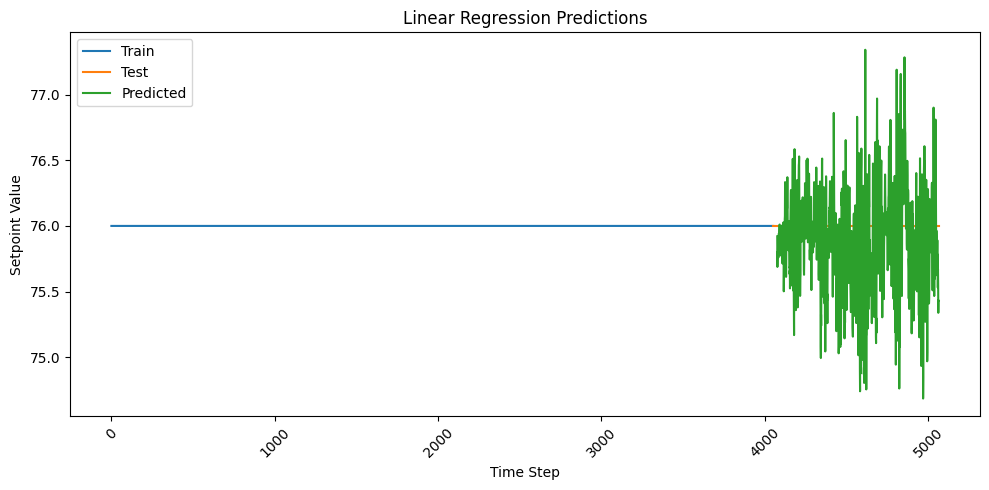

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(heating_train_data.index, heating_train_data["setpoint"], label="Train")
plt.plot(heating_test_data.index, heating_test_data["setpoint"], label="Test")
plt.plot(heating_test_data.index[24:], heating_test_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
heating_train_predictions, _ = evaluate(heating_model, heating_train_loader)

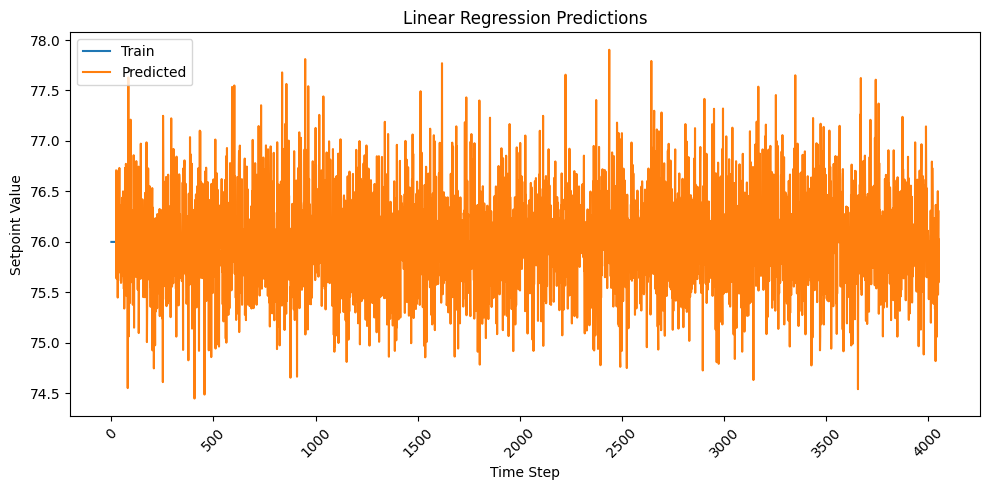

In [27]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(heating_train_data.index, heating_train_data["setpoint"], label="Train")
plt.plot(heating_train_data.index[24:], heating_train_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cooling prediction

In [28]:
train_split = 0.8

cooling_train_data = cooling_data[:int(len(cooling_data) * train_split)]
cooling_test_data = cooling_data[int(len(cooling_data) * train_split):]

In [29]:
cooling_train_sequences, cooling_train_labels = generate_sequences(cooling_train_data)
cooling_test_sequences, cooling_test_labels = generate_sequences(cooling_test_data)

In [30]:
cooling_train_sequences = cooling_train_sequences.reshape(cooling_train_sequences.shape[0], -1)
cooling_test_sequences = cooling_test_sequences.reshape(cooling_test_sequences.shape[0], -1)

In [31]:
batch_size = 32

cooling_train_dataset = Dataset(X=cooling_train_sequences, y=cooling_train_labels)
cooling_test_dataset = Dataset(X=cooling_test_sequences, y=cooling_test_labels)

cooling_train_loader = DataLoader(cooling_train_dataset, batch_size=batch_size, shuffle=True)
cooling_test_loader = DataLoader(cooling_test_dataset, batch_size=batch_size, shuffle=False)

## Instantiate model

In [32]:
cooling_model = LinearRegressionModel(input_size=cooling_train_sequences.shape[1], output_size=1)

In [33]:
criterion = nn.MSELoss()
optimizer = optim.Adam(cooling_model.parameters(), lr=0.001)

In [34]:
num_epochs = 10
train(cooling_model, cooling_train_loader, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/10, Loss: 168.8062
Epoch 2/10, Loss: 6.7240
Epoch 3/10, Loss: 5.0561
Epoch 4/10, Loss: 3.7109
Epoch 5/10, Loss: 2.6310
Epoch 6/10, Loss: 1.8819
Epoch 7/10, Loss: 1.4040
Epoch 8/10, Loss: 1.0954
Epoch 9/10, Loss: 0.9169
Epoch 10/10, Loss: 0.8054


In [35]:
cooling_test_predictions, actuals = evaluate(cooling_model, cooling_test_loader)

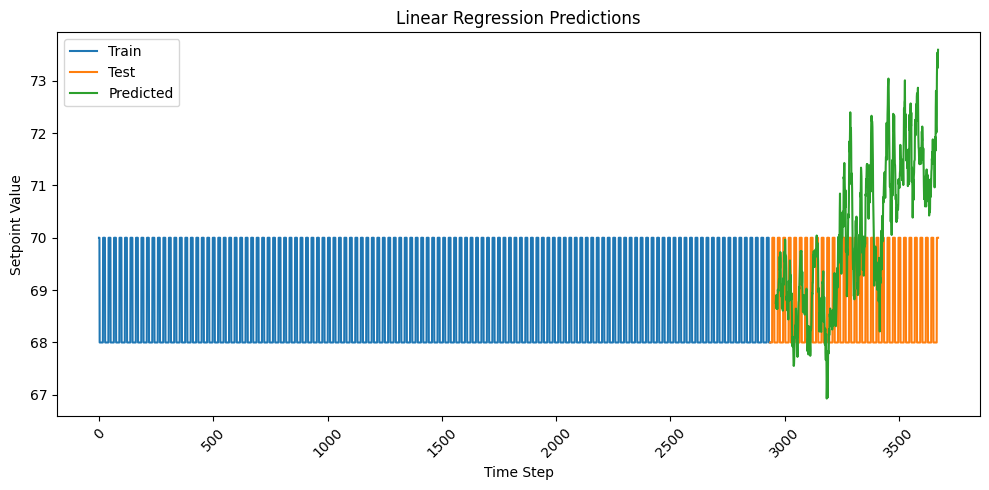

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(cooling_train_data.index, cooling_train_data["setpoint"], label="Train")
plt.plot(cooling_test_data.index, cooling_test_data["setpoint"], label="Test")
plt.plot(cooling_test_data.index[24:], cooling_test_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
cooling_train_predictions, _ = evaluate(cooling_model, cooling_train_loader)

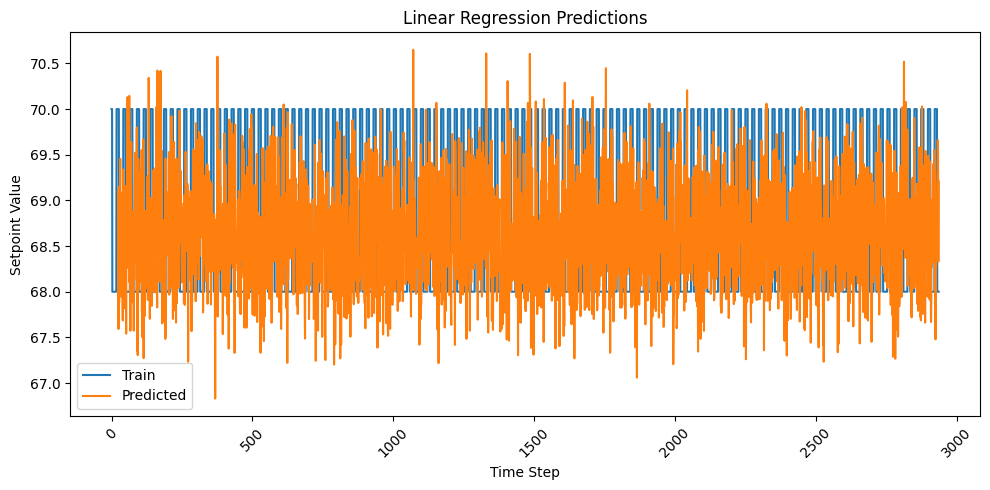

In [38]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(cooling_train_data.index, cooling_train_data["setpoint"], label="Train")
plt.plot(cooling_train_data.index[24:], cooling_train_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot heating and cooling predictions

In [39]:
heating_predictions = np.concatenate([heating_train_predictions, heating_test_predictions])
cooling_predictions = np.concatenate([cooling_train_predictions, cooling_test_predictions])

7324

In [40]:
date_range = np.arange(0, 8760)

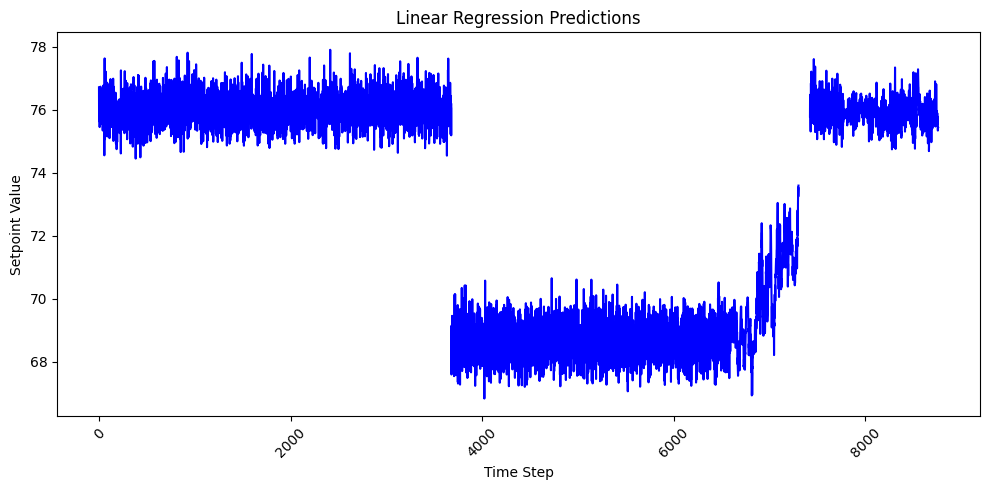

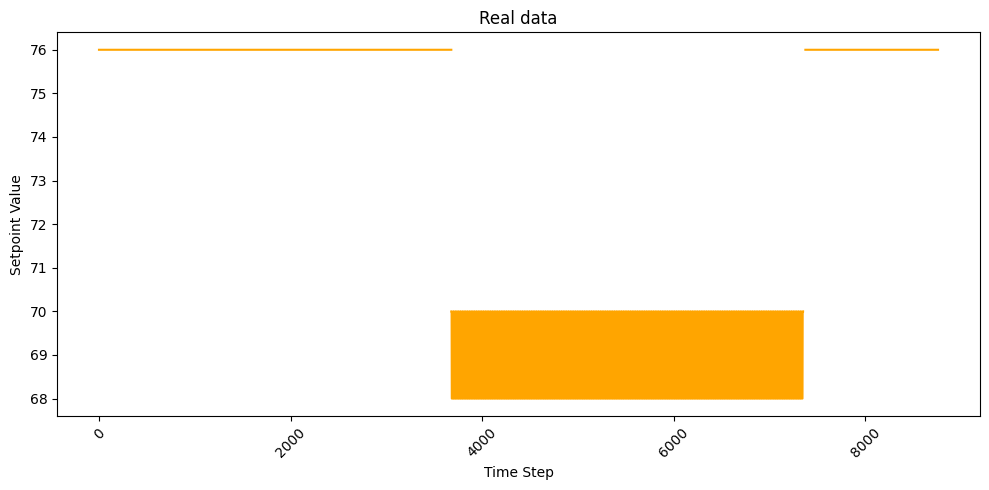

In [41]:
# Plot the heating and cooling train and test predictions
plt.figure(figsize=(10, 5))
plt.plot(date_range[:3679], heating_predictions[:3679], label="Heating Predicted", color='blue')
plt.plot(date_range[3679:7303], cooling_predictions, label="Cooling Predicted", color='blue')
plt.plot(date_range[7422:], heating_predictions[3679:], color='blue')
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(date_range[:3679], heating_data.iloc[:3679]["setpoint"], label="Heating Data", color='orange')
plt.plot(date_range[3679:7351], cooling_data["setpoint"], label="Cooling Data", color='orange')
plt.plot(date_range[7374:], heating_data.iloc[3679:]["setpoint"], color='orange')
plt.title("Real data")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
for param in heating_model.parameters():
    print(param.data)

tensor([[-0.0272,  0.0374, -0.0378,  0.1441, -0.0608, -0.0235,  0.0950,  0.1246,
          0.0258, -0.0441,  0.1278, -0.0660, -0.0113, -0.0448,  0.1025, -0.0084,
          0.0819,  0.0589,  0.1311,  0.0905,  0.0024,  0.1492, -0.0186, -0.0309,
          0.1393,  0.0273,  0.0015, -0.0473,  0.1284,  0.1046, -0.0028,  0.0641,
          0.0269, -0.0579,  0.0689, -0.0434,  0.1165, -0.0179, -0.0826, -0.0073,
         -0.0338, -0.0727,  0.0894,  0.1130,  0.0291, -0.0355,  0.0534,  0.1086,
          0.1273, -0.0544, -0.0212, -0.0691,  0.1438, -0.0123,  0.1211,  0.1530,
         -0.0416, -0.0103, -0.0527,  0.1503, -0.0079, -0.0070, -0.0446,  0.0114,
          0.0235, -0.0366,  0.0392, -0.0687,  0.0509,  0.1368,  0.1458, -0.0370]])
tensor([0.0805])
